**Audrey Quessada**  
MDI341

# TP 4 : Champs aléatoires conditionnels pour une séquence de marquage

Le but de ce TP est d'implémenter un CRF de chaîne linéaire pour l'extraction d'entités nommées dans un texte.  
Dans un premier temps, on va apprendre à se servir du package `pycrfsuite` sur des données de texte déjà existantes. Dans la deuxième partie du TP, on implémentera un algorithme de Viterbi. Cet algorithme a pour but de trouver la séquence d'états la plus probable (ou chemin optimal) ayant produit une séquence mesurée particulière.   


### 1.1 Named Entity Recognition task

Le NER permet d'extraire des informations d'un texte et donc toutes les phrases ou entités nommées contenant les champs nom d'une personne, lieu, organisation, temps et quantité. 
L'article de Altun et Yasemin *Discriminative Learning for Label Sequences via Boosting* met en avant une nouvelle methode utilisant du boosting pour discriminer les labels de séquences, choses que ne font pas les HMM. La discrimination se fait en maximisant le critère de vraisemblance conditionnelle. Dans cet article, les auteurs utilisent une fonction de perte exponentielle plutôt que logarithmique et du boosting.

### 1.2 Le jeu de données

http://www.cnts.ua.ac.be/conll2002/pdf/15558tjo.pdf  
Tous les fichiers de données contiennent un mot par ligne représentant les limites de la phrase et un label permettant de reconnaître le type de nom (personne, lieu, organisation). Le label s'écrit comme `B-XXX` ou `I-XXX` où `XXX` est le type de nom (`PER`, `LOC`, `ORG`, `MISC`) et `B` indique que c'est le premier label de ce type trouvé alors que `I` indique qu'il s'agit d'un label appartenant à un même ensemble de labels déjà existants. On a donc au total 9 labels en comptant également `O` pour les mots non classés dans les catégories précédentes Il est supposé que les entités nommées ne se recouvrent pas et ne sont pas récurrentes.  
  
Le jeu de données d'entrainement consiste en 7230 phrases de longueur moyenne 36 mots, chaque mot étant marqué par un label de type POS (Part of Speech).

### 2 .1 Python crfsuite

Génération d'entités (attribut)
L'étape suivante consiste à prétraiter les données de formation et de test pour extraire les attributs qui expriment les caractéristiques des mots (éléments) dans les données. CRFsuite génère en interne des fonctionnalités à partir d'attributs dans un ensemble de données. En général, c'est le processus le plus important pour les approches de machine-learning, car la conception d'une caractéristique affecte grandement la précision de l'étiquetage. Dans ce tutoriel, nous extrayons 19 types d'attributs d'un mot à la position t (en offsets du début d'une séquence)  
Dans cette liste w [t] et pos [t] présentent le mot et la partie de parole respectivement à la position t dans une séquence. Ces caractéristiques expriment la caractéristique du mot à la position t en utilisant l'information des mots environnants, par exemple, w [t-1] et pos [t + 1]. Par exemple, le jeton 'the' dans l'exemple suivant

### 2.2 Utilisation du notebook CoNLL 2002

In [1]:
import nltk
import pandas as pd
import _pickle as pickle
import numpy as np
import sklearn
import pycrfsuite
import seaborn as sns
import time
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from IPython.display import display, HTML
from itertools import chain

print(sklearn.__version__)
warnings.filterwarnings('ignore')
%matplotlib inline

0.18.1


On utilise les données espagnoles du corpus CoNLL 2002 de NLTK

In [2]:
nltk.corpus.conll2002.fileids()

['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [3]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
print('la longueur du training set esp.train est:')
print(len(train_sents))
print('la longueur du test set esp.testb est:')
print(len(test_sents))


la longueur du training set esp.train est:
8323
la longueur du test set esp.testb est:
1517
CPU times: user 2.28 s, sys: 28 ms, total: 2.31 s
Wall time: 2.31 s


Format des données

In [4]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

On définit ensuite des features. Dans cet exemple, on utilise l'identité du mot, le suffixe, la forme et le label de type POS. Il y a également des informations concernant les mots autour de celui qui nous intéresse:  
* le mot commence-t'il avec une majuscule ou une minuscule?
* le mot est-il un nombre ou un titre?
* quels sont les mots qui entourent le mot en question?
* quel est le POS tag du mot?


In [5]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag[:2]=' + postag[:2],
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:postag=' + postag1,
            '-1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:postag=' + postag1,
            '+1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('EOS')
                
    return features

Test de la fonction `word2features`

In [6]:
word2features(train_sents[0],8)

['bias',
 'word.lower=efe',
 'word[-3:]=EFE',
 'word[-2:]=FE',
 'word.isupper=True',
 'word.istitle=False',
 'word.isdigit=False',
 'postag=NC',
 'postag[:2]=NC',
 '-1:word.lower=(',
 '-1:word.istitle=False',
 '-1:word.isupper=False',
 '-1:postag=Fpa',
 '-1:postag[:2]=Fp',
 '+1:word.lower=)',
 '+1:word.istitle=False',
 '+1:word.isupper=False',
 '+1:postag=Fpt',
 '+1:postag[:2]=Fp']

In [7]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]    

Test de la fonction `sent2features`

In [8]:
sent2features(train_sents[0])

[['bias',
  'word.lower=melbourne',
  'word[-3:]=rne',
  'word[-2:]=ne',
  'word.isupper=False',
  'word.istitle=True',
  'word.isdigit=False',
  'postag=NP',
  'postag[:2]=NP',
  'BOS',
  '+1:word.lower=(',
  '+1:word.istitle=False',
  '+1:word.isupper=False',
  '+1:postag=Fpa',
  '+1:postag[:2]=Fp'],
 ['bias',
  'word.lower=(',
  'word[-3:]=(',
  'word[-2:]=(',
  'word.isupper=False',
  'word.istitle=False',
  'word.isdigit=False',
  'postag=Fpa',
  'postag[:2]=Fp',
  '-1:word.lower=melbourne',
  '-1:word.istitle=True',
  '-1:word.isupper=False',
  '-1:postag=NP',
  '-1:postag[:2]=NP',
  '+1:word.lower=australia',
  '+1:word.istitle=True',
  '+1:word.isupper=False',
  '+1:postag=NP',
  '+1:postag[:2]=NP'],
 ['bias',
  'word.lower=australia',
  'word[-3:]=lia',
  'word[-2:]=ia',
  'word.isupper=False',
  'word.istitle=True',
  'word.isdigit=False',
  'postag=NP',
  'postag[:2]=NP',
  '-1:word.lower=(',
  '-1:word.istitle=False',
  '-1:word.isupper=False',
  '-1:postag=Fpa',
  '-1:post

Test de la fonction `sent2labels`

In [9]:
sent2labels(train_sents[0])

['B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']

Test de la fonction `sent2tokens`

In [10]:
sent2tokens(train_sents[0])

['Melbourne', '(', 'Australia', ')', ',', '25', 'may', '(', 'EFE', ')', '.']

On extrait maintenant les caractéristiques des données

In [11]:
%%time

CRFSUITE_TEST_DATA_FILE = '/home/audrey/nltk_data/corpora/conll2002/conll2002-esp_crfsuite-test-data.dump'

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]
pickle.dump({'X': X_test, 'y': y_test}, open(CRFSUITE_TEST_DATA_FILE, 'wb'))
data = pickle.load(open(CRFSUITE_TEST_DATA_FILE, 'rb'))

CPU times: user 2.68 s, sys: 160 ms, total: 2.84 s
Wall time: 2.84 s


#### 2.2.1 Entrainement du modèle `lbfgs` et elastic net

On utilise pour cela crfsuite et on crée un objet Trainer qu'on va entrainer sur nos données train (http://python-crfsuite.readthedocs.io/en/latest/pycrfsuite.html)

In [12]:
%%time
trainer_model1 = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer_model1.append(xseq, yseq)

CPU times: user 4.19 s, sys: 40 ms, total: 4.23 s
Wall time: 4.23 s


On va utiliser l'algorithme par défaut (`lbfgs`) et des paramètres de régularisations $l1$ et $l2$ , avec dans un premier temps une régularisation elastic net

In [13]:
trainer_model1.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 50,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [14]:
trainer_model1.params()

['feature.minfreq',
 'feature.possible_states',
 'feature.possible_transitions',
 'c1',
 'c2',
 'max_iterations',
 'num_memories',
 'epsilon',
 'period',
 'delta',
 'linesearch',
 'max_linesearch']

Entrainement du modèle 

In [15]:
%%time
trainer_model1.train('conll2002-esp.crfsuite')

CPU times: user 19.4 s, sys: 12 ms, total: 19.4 s
Wall time: 19.4 s


On peut sauvegarder le résultat dans un fichier

In [16]:
!ls -lh ./conll2002-esp.crfsuite

-rw-rw-r-- 1 audrey audrey 601K mars  29 13:59 ./conll2002-esp.crfsuite


On peut également obtenir les information sur l'état final du modèle grâce à la fonction `logparser` du `trainer`

In [17]:
trainer_model1.logparser.last_iteration

{'active_features': 11346,
 'error_norm': 1262.912078,
 'feature_norm': 79.110017,
 'linesearch_step': 1.0,
 'linesearch_trials': 1,
 'loss': 14807.577946,
 'num': 50,
 'scores': {},
 'time': 0.358}

On récupère également les informations pour chaque itération:

In [18]:
print(len(trainer_model1.logparser.iterations), trainer_model1.logparser.iterations[-1])

50 {'feature_norm': 79.110017, 'error_norm': 1262.912078, 'linesearch_step': 1.0, 'loss': 14807.577946, 'linesearch_trials': 1, 'num': 50, 'scores': {}, 'time': 0.358, 'active_features': 11346}


In [19]:
loss_it = [trainer_model1.logparser.iterations[i]['error_norm'] for i in range(len(trainer_model1.logparser.iterations))]


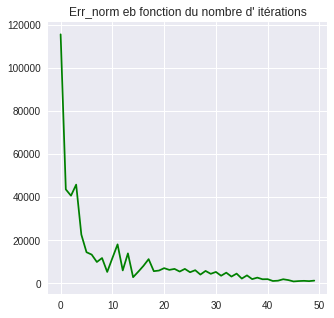

In [20]:
it = [i for i in range (len(trainer_model1.logparser.iterations))]
fig = plt.figure(figsize=(5,5))
plt.plot(it,loss_it, "g")
plt.title('Err_norm eb fonction du nombre d\' itérations')

#### 2.2.2 Prédictions avec ce modèle

On utilise l'objet tagger

In [21]:
tagger = pycrfsuite.Tagger()
tagger.open('conll2002-esp.crfsuite')


On va tester en marquant une phrase

In [22]:
example_sent = test_sents[0]
print(' '.join(sent2tokens(example_sent)), end='\n\n')

print("Predicted:", ' '.join(tagger.tag(sent2features(example_sent))))
print("Correct:  ", ' '.join(sent2labels(example_sent)))

La Coruña , 23 may ( EFECOM ) .

Predicted: B-LOC I-LOC O O O O B-ORG O O
Correct:   B-LOC I-LOC O O O O B-ORG O O


#### 2.2.3 Evaluation du modèle

In [23]:
def bio_classification_report(y_true, y_pred):
    """
    Classification report for a list of BIO-encoded sequences.
    It computes token-level metrics and discards "O" labels.
    
    Note that it requires scikit-learn 0.15+ (or a version from github master)
    to calculate averages properly!
    """
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    )

Prediction des labels pour toutes les phrases du test ('testb' Spanish data):  

In [24]:
%%time
y_pred = [tagger.tag(xseq) for xseq in X_test]

CPU times: user 624 ms, sys: 16 ms, total: 640 ms
Wall time: 641 ms


In [25]:
print(bio_classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      B-LOC       0.78      0.75      0.76      1084
      I-LOC       0.66      0.60      0.63       325
     B-MISC       0.69      0.47      0.56       339
     I-MISC       0.61      0.49      0.54       557
      B-ORG       0.79      0.81      0.80      1400
      I-ORG       0.80      0.79      0.80      1104
      B-PER       0.82      0.87      0.84       735
      I-PER       0.87      0.93      0.90       634

avg / total       0.77      0.76      0.76      6178



On définit une fonction qui récupère le f1-score moyen sur le rapport de classification, ce qui nous permettra de comparer des modèles.

In [26]:
def get_avg_f1_from_report(report):
    report = report.split(' ')
    report = [el.replace('\n','') for el in report if el!='']
    return float(report[-2])

On affiche les poids des transitions grâce au tagger

In [27]:
trans = tagger.info().transitions
index_transition = [i for i in range(len(trans))]
df_transition = pd. DataFrame(trans, index= index_transition, dtype=None)
print(display(df_transition))

B-LOC                                                              \
       B-LOC    B-MISC     B-ORG     B-PER     I-LOC    I-MISC     I-ORG   
0   1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
1   1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
2   1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
3   1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
4   1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
5   1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
6   1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
7   1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
8   1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
9   1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
10  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
11  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
12  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
13  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
14  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
15  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
16  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
17  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
18  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
19  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
20  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
21  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
22  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
23  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
24  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
25  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
26  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
27  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
28  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
29  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
..       ...       ...       ...       ...       ...       ...       ...   
51  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
52  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
53  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
54  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
55  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
56  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
57  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
58  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
59  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
60  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
61  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
62  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
63  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
64  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
65  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
66  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
67  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
68  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
69  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1.652467 -0.393017   
70  1.240278 -0.321851 -1.046767 -0.006419  6.913675 -1

None


#### 2.2.4 Entrainement du modèle `lbfgs` et lasso

In [28]:
%%time
trainer_model2 = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer_model2.append(xseq, yseq)

CPU times: user 3.88 s, sys: 76 ms, total: 3.96 s
Wall time: 3.96 s


In [29]:
trainer_model2.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 0,  # coefficient for L2 penalty
    'max_iterations': 50,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [30]:
%%time
trainer_model2.train('conll2002-esp2.crfsuite')

CPU times: user 19.6 s, sys: 8 ms, total: 19.6 s
Wall time: 19.6 s


In [31]:
!ls -lh ./conll2002-esp2.crfsuite

-rw-rw-r-- 1 audrey audrey 630K mars  29 14:00 ./conll2002-esp2.crfsuite


In [32]:
trainer_model2.logparser.last_iteration

{'active_features': 11961,
 'error_norm': 535.051489,
 'feature_norm': 78.049247,
 'linesearch_step': 1.0,
 'linesearch_trials': 1,
 'loss': 14893.161153,
 'num': 50,
 'scores': {},
 'time': 0.369}

In [33]:
print(len(trainer_model2.logparser.iterations), trainer_model2.logparser.iterations[0],trainer_model2.logparser.iterations[-1])


50 {'feature_norm': 1.0, 'error_norm': 115688.571415, 'linesearch_step': 2e-06, 'loss': 164767.733635, 'linesearch_trials': 1, 'num': 1, 'scores': {}, 'time': 0.685, 'active_features': 51798} {'feature_norm': 78.049247, 'error_norm': 535.051489, 'linesearch_step': 1.0, 'loss': 14893.161153, 'linesearch_trials': 1, 'num': 50, 'scores': {}, 'time': 0.369, 'active_features': 11961}


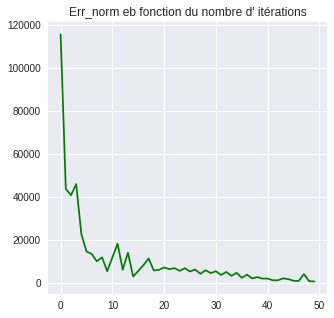

In [34]:
loss_it2 = [trainer_model2.logparser.iterations[i]['error_norm'] for i in range(len(trainer_model2.logparser.iterations))]
it2 = [i for i in range (len(trainer_model2.logparser.iterations))]
fig = plt.figure(figsize=(5,5))
plt.plot(it2,loss_it2, "g")
plt.title('Err_norm eb fonction du nombre d\' itérations')


**Prédictions avec ce modèle**

In [35]:
tagger2 = pycrfsuite.Tagger()
tagger2.open('conll2002-esp2.crfsuite')

In [36]:
example_sent = test_sents[0]
print(' '.join(sent2tokens(example_sent)), end='\n\n')

print("Predicted:", ' '.join(tagger2.tag(sent2features(example_sent))))
print("Correct:  ", ' '.join(sent2labels(example_sent)))

La Coruña , 23 may ( EFECOM ) .

Predicted: B-LOC I-LOC O O O O B-ORG O O
Correct:   B-LOC I-LOC O O O O B-ORG O O


**Evaluation du modèle**

In [37]:
%%time
y_pred = [tagger2.tag(xseq) for xseq in X_test]
report = bio_classification_report(y_test, y_pred)
print(report)
print(get_avg_f1_from_report(report))

             precision    recall  f1-score   support

      B-LOC       0.78      0.75      0.76      1084
      I-LOC       0.65      0.58      0.61       325
     B-MISC       0.68      0.47      0.56       339
     I-MISC       0.60      0.48      0.53       557
      B-ORG       0.79      0.80      0.80      1400
      I-ORG       0.80      0.79      0.79      1104
      B-PER       0.81      0.88      0.84       735
      I-PER       0.88      0.93      0.90       634

avg / total       0.77      0.75      0.76      6178

0.76
CPU times: user 756 ms, sys: 20 ms, total: 776 ms
Wall time: 778 ms


In [38]:
trans2 = tagger2.info().transitions
index_transition2 = [i for i in range(len(trans2))]
df_transition2 = pd. DataFrame(trans2, index= index_transition2, dtype=None)
print(display(df_transition2))

B-LOC                                                              \
       B-LOC    B-MISC     B-ORG     B-PER     I-LOC    I-MISC     I-ORG   
0   1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
1   1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
2   1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
3   1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
4   1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
5   1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
6   1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
7   1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
8   1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
9   1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
10  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
11  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
12  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
13  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
14  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
15  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
16  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
17  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
18  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
19  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
20  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
21  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
22  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
23  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
24  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
25  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
26  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
27  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
28  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
29  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
..       ...       ...       ...       ...       ...       ...       ...   
51  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
52  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
53  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
54  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
55  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
56  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
57  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
58  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
59  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
60  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
61  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
62  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
63  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
64  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
65  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
66  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
67  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
68  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
69  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1.752642 -0.600844   
70  1.231849 -0.420626 -0.952005 -0.014468  6.592379 -1

None


#### 2.2.5 Entrainement du modèle `lbfgs` et Ridge

In [39]:
%%time
trainer_model3 = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer_model3.append(xseq, yseq)

CPU times: user 4.06 s, sys: 64 ms, total: 4.12 s
Wall time: 4.12 s


In [40]:
trainer_model3.set_params({
    'c1': 0,   # coefficient for L1 penalty
    'c2': 1,  # coefficient for L2 penalty
    'max_iterations': 50,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [41]:
%%time
trainer_model3.train('conll2002-esp3.crfsuite')

CPU times: user 20 s, sys: 20 ms, total: 20 s
Wall time: 20.1 s


In [42]:
!ls -lh ./conll2002-esp3.crfsuite


-rw-rw-r-- 1 audrey audrey 6,5M mars  29 14:00 ./conll2002-esp3.crfsuite


In [43]:
trainer_model3.logparser.last_iteration

{'active_features': 96180,
 'error_norm': 3149.189174,
 'feature_norm': 32.7279,
 'linesearch_step': 1.0,
 'linesearch_trials': 1,
 'loss': 19194.350871,
 'num': 50,
 'scores': {},
 'time': 0.377}

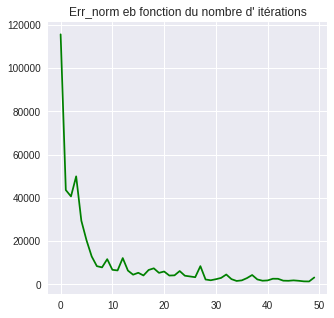

In [44]:
loss_it3 = [trainer_model3.logparser.iterations[i]['error_norm'] for i in range(len(trainer_model3.logparser.iterations))]
it3 = [i for i in range (len(trainer_model3.logparser.iterations))]
fig = plt.figure(figsize=(5,5))
plt.plot(it3,loss_it3, "g")
plt.title('Err_norm eb fonction du nombre d\' itérations')

**Prédictions avec ce modèle**

In [45]:
tagger3 = pycrfsuite.Tagger()
tagger3.open('conll2002-esp3.crfsuite')
print("Predicted:", ' '.join(tagger3.tag(sent2features(example_sent))))
print("Correct:  ", ' '.join(sent2labels(example_sent)))

Predicted: B-LOC I-LOC O O O O B-ORG O O
Correct:   B-LOC I-LOC O O O O B-ORG O O


**Evaluation de ce modèle **

In [46]:
%%time
y_pred = [tagger3.tag(xseq) for xseq in X_test]
report2 = bio_classification_report(y_test, y_pred)
print(report2)
print(get_avg_f1_from_report(report2))

             precision    recall  f1-score   support

      B-LOC       0.67      0.71      0.69      1084
      I-LOC       0.48      0.46      0.47       325
     B-MISC       0.55      0.25      0.34       339
     I-MISC       0.70      0.37      0.48       557
      B-ORG       0.76      0.74      0.75      1400
      I-ORG       0.77      0.75      0.76      1104
      B-PER       0.72      0.84      0.77       735
      I-PER       0.76      0.91      0.83       634

avg / total       0.71      0.69      0.69      6178

0.69
CPU times: user 792 ms, sys: 8 ms, total: 800 ms
Wall time: 802 ms


In [47]:
trans3 = tagger3.info().transitions
index_transition3 = [i for i in range(len(trans3))]
df_transition3 = pd. DataFrame(trans3, index= index_transition3, dtype=None)
print(display(df_transition3))

B-LOC                                                            \
       B-LOC    B-MISC    B-ORG     B-PER    I-LOC    I-MISC     I-ORG   
0   0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
1   0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
2   0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
3   0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
4   0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
5   0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
6   0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
7   0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
8   0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
9   0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
10  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
11  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
12  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
13  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
14  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
15  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
16  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
17  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
18  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
19  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
20  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
21  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
22  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
23  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
24  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
25  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
26  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
27  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
28  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
29  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
..       ...       ...      ...       ...      ...       ...       ...   
51  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
52  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
53  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
54  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
55  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
56  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
57  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
58  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
59  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
60  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
61  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
62  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
63  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
64  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
65  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
66  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
67  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
68  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
69  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
70  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
71  0.202266 -0.256383 -0.47227 -0.323117  6.32407 -1.225386 -1.434577   
72  0.20226

None


#### 2.2.6 Variations des paramètres de régularisation du modèle `lbfgs`

On peut maintenant regarder ce qui se passe en faisant varier les paramètres C1 et C2 des régularisations

In [48]:
c1 = [1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100]
c2 = [1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100]
errnorm_lastIter = []
loss_lastIter = []
f1_score = []

In [49]:
%%time
trainer_model4 = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer_model4.append(xseq, yseq)

CPU times: user 3.9 s, sys: 48 ms, total: 3.94 s
Wall time: 3.95 s


In [50]:
k = 4
for i in c1:
    start = time.time()
    for j in c2:
        trainer_model4.set_params({'c1': i, 'c2': j, 'max_iterations': 50,'feature.possible_transitions': True })
        file = 'conll2002-esp'+str(k)+'.crfsuite'
        trainer_model4.train(file)
        lastIter = trainer_model4.logparser.last_iteration
        errnorm = lastIter['error_norm']
        loss = lastIter['loss']
        errnorm_lastIter.append(errnorm)
        loss_lastIter.append(loss)
        tagger4 = pycrfsuite.Tagger()
        tagger4.open(file)
        y_pred = [tagger4.tag(xseq) for xseq in X_test]
        rep = bio_classification_report(y_test, y_pred)
        f1 = get_avg_f1_from_report(rep)
        f1_score.append(f1)
        print('loop #',k-4)
        print(i,j,f1)
        print('--------------------')
        k += 1
    stop = time.time()
    print(stop-start)
print(errnorm_lastIter)
print(loss_lastIter)
print(f1_score)    

loop # 0
1e-05 1e-05 0.76
--------------------
loop # 1
1e-05 0.0001 0.77
--------------------
loop # 2
1e-05 0.001 0.78
--------------------
loop # 3
1e-05 0.01 0.79
--------------------
loop # 4
1e-05 0.1 0.79
--------------------
loop # 5
1e-05 0 0.75
--------------------
loop # 6
1e-05 1 0.77
--------------------
loop # 7
1e-05 10 0.7
--------------------
loop # 8
1e-05 100 0.6
--------------------
183.0800154209137
loop # 9
0.0001 1e-05 0.76
--------------------
loop # 10
0.0001 0.0001 0.77
--------------------
loop # 11
0.0001 0.001 0.78
--------------------
loop # 12
0.0001 0.01 0.79
--------------------
loop # 13
0.0001 0.1 0.79
--------------------
loop # 14
0.0001 0 0.76
--------------------
loop # 15
0.0001 1 0.77
--------------------
loop # 16
0.0001 10 0.7
--------------------
loop # 17
0.0001 100 0.6
--------------------
182.79301810264587
loop # 18
0.001 1e-05 0.78
--------------------
loop # 19
0.001 0.0001 0.78
--------------------
loop # 20
0.001 0.001 0.79
----------

Plot pour observer l'influence des régularisations

In [51]:
log_errnorm_lastIter = list(map(np.log10, errnorm_lastIter))
print(len(log_errnorm_lastIter))
log_errnorm_lastIter = np.array(log_errnorm_lastIter).reshape(9,9)
f1_score = np.array(f1_score).reshape(9,9)


81


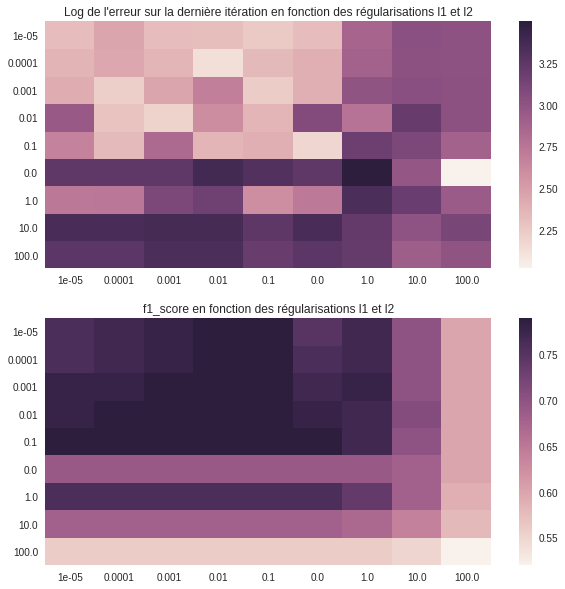

In [52]:
fig = plt.figure(figsize=(10,10))
yticks = np.array(c2)
xticks = np.array(c1)
ax1 = fig.add_subplot(211)
sns.heatmap(log_errnorm_lastIter, xticklabels=xticks, yticklabels=yticks)
plt.title('Log de l\'erreur sur la dernière itération en fonction des régularisations l1 et l2')
ax2 = fig.add_subplot(212)
sns.heatmap(f1_score, xticklabels=xticks, yticklabels=yticks)
plt.title('f1_score en fonction des régularisations l1 et l2')


**Conclusion** : on voit que les meilleurs f1-scores sont obtenus pour des paramètres de régularisation de type elastic net avec $l1$ et $l2$ de l'ordre de 0.1. Pour des valeurs de ($l1$, $l2$) plus grandes que (1,1), les performances du modèle se dégradent.

### 3 Codage d'une routine de type CRF en python

In [53]:
from flexcrf_tp.models.linear_chain import (_feat_fun_values,
                                            _compute_all_potentials,
                                            _forward_score,
                                            _backward_score,
                                            _partition_fun_value,
                                            _posterior_score)

from  flexcrf_tp.crfsuite2flexcrf import convert_data_to_flexcrf


#### 3.1 Implémentation du Viterbi decoder

In [54]:
def viterbi_decoder(m_xy, n=None, log_version=True):
    """
    Performs MAP inference, determining $y = \argmax_y P(y|x)$, using the
    Viterbi algorithm.

    Parameters
    ----------
    m_xy : ndarray, shape (n_obs, n_labels, n_labels)
        Values of log-potentials ($\log M_i(y_{i-1}, y_i, x)$)
        computed based on feature functions f_xy and/or user-defined potentials
        `psi_xy`. At t=0, m_xy[0, 0, :] contains values of $\log M_1(y_0, y_1)$
        with $y_0$ the fixed initial state.

    n : integer, default=None
        Time position up to which to decode the optimal sequence; if not
        specified (default) the score is computed for the whole sequence.

    Returns
    -------
    y_pred : ndarray, shape (n_obs,)
        Predicted optimal sequence of labels.

    """

    # nombre d'états
    n_obs = m_xy.shape[0]
    n_states = m_xy.shape[1]
    y_pred = np.zeros(n_obs)
    
    # initialisation
    delta = np.zeros((n_obs, n_states))
    psi = np.zeros((n_obs, n_states))
    
    #initialisation de la récurrence
    delta[0,:] = m_xy[0,0,:]
    psi[0,:] = 0

    # récurrence
    for i in range(1, n_obs):
        #pour chaque observation, on vérifie le meilleur chemin vers chaque état
        for j in range(n_states):
            # pour une observation donnée, on vérifie la proba de chaque chemin
            temp_probs = delta[i-1, :] + m_xy[i, :, j]
            
            # on vérifie le plus grand score
            psi[i,j] = np.argmax(temp_probs)
            delta[i, j] = temp_probs[psi[i, j]]

            
    # on calcule y_pred associé
    y_pred[n_obs - 1] = np.argmax(delta[n_obs-1, :])
    
    # Path backtracking
    for i in range(n_obs-2, -1, -1):
        y_pred[i] = int(psi[i+1, y_pred[i+1]])
        
    return y_pred


#### 3.2 CRF suite 

In [55]:
# -- Load data and crfsuite model and convert them-------------------------

RECREATE = True  # set to True to recreate flexcrf data with new model

CRFSUITE_MODEL_FILE = '/home/audrey/nltk_data/corpora/conll2002/conll2002-esp.crfsuite'
CRFSUITE_TEST_DATA_FILE = '/home/audrey/nltk_data/corpora/conll2002/conll2002-esp_crfsuite-test-data.dump'
FLEXCRF_TEST_DATA_FILE = '/home/audrey/nltk_data/corpora/conll2002/conll2002-esp_flexcrf-test-data.dump'

In [56]:
# crfsuite model
tagger = pycrfsuite.Tagger()
tagger.open(CRFSUITE_MODEL_FILE)
model = tagger.info()

data = pickle.load(open(CRFSUITE_TEST_DATA_FILE, 'rb'))
print("test data loaded.")

if RECREATE:
    dataset, thetas = convert_data_to_flexcrf(data, model, n_seq=3)
    pickle.dump({'dataset': dataset, 'thetas': thetas},
                open(FLEXCRF_TEST_DATA_FILE,'wb'))
else:
    dd = pickle.load(open(FLEXCRF_TEST_DATA_FILE))
    dataset = dd['dataset']
    thetas = dd['thetas']

test data loaded.

converting to flexcrf format...
f_xy_desc created.
t_xyy_desc created
Processing sentence 1/3...
Processing sentence 2/3...
Processing sentence 3/3...


#### 3.3 classification

In [57]:
# -- Start classification ------------------------------------------------

for seq in range(len(dataset)):
    # -- with crfsuite
    s_ = tagger.tag(data['X'][seq])
    y_ = np.array([int(model.labels[s]) for s in s_])
    prob_ = tagger.probability(s_)

    print("\n-- With crfsuite:")
    print("labels:\n", s_, "\n", y_)
    print("probability:\t %f" % prob_)

    # -- with flexcrf
    f_xy, y = dataset[seq]
    theta = thetas[seq]

    m_xy, f_m_xy = _compute_all_potentials(f_xy, theta)
    y_pred = viterbi_decoder(m_xy)

    alpha = _forward_score(m_xy=m_xy)
    beta = _backward_score(m_xy=m_xy)
    z_x = _partition_fun_value(alpha=alpha)
    f_x = _feat_fun_values( f_xy=f_xy, y=y_pred, with_f_x_sum=False)

    prob = np.exp(_posterior_score(f_x=f_x, theta=theta, psi_x=None  , z_x=z_x))
    print("-- With flexcrf:")
    print("labels:\n", y_pred)
    print("equal predictions: ", np.all(y_pred == y_))
    print ("probability:\t %f" % prob)
    print ("delta:\t %f" % abs(prob-prob_))

tagger.close()
    


-- With crfsuite:
labels:
 ['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O'] 
 [0 7 1 1 1 1 2 1 1]
probability:	 0.930321
-- With flexcrf:
labels:
 [ 0.  7.  1.  1.  1.  1.  2.  1.  1.]
equal predictions:  True
probability:	 0.930321
delta:	 0.000000

-- With crfsuite:
labels:
 ['O'] 
 [1]
probability:	 0.999996
-- With flexcrf:
labels:
 [ 1.]
equal predictions:  True
probability:	 0.999996
delta:	 0.000000

-- With crfsuite:
labels:
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O'] 
 [1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 3 4 4 1 1 1 1 1 0 7 1]
probability:	 0.437425
-- With flexcrf:
labels:
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  5.  1.  1.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

On obtient les mêmes résultats avec Viterbi home-made et crfsuite.

### 4. Pour aller plus loin

#### 4.1 Le corpus anglais  
  
On va dans un premier temps tester au cropus anglais les fonctions définies précédemment avec les meilleurs paramètres de régularisation trouvés pour le corpus espagnol (par exemple $l1=l2=0.1$).  
On va executer l'entrainement du modèle puis l'évaluation de celui-ci.

In [58]:
train_sents_engl = list(nltk.corpus.conll2000.iob_sents('train.txt'))
test_sents_engl = list(nltk.corpus.conll2000.iob_sents('test.txt'))

print('la longueur du training set engl.train est:')
print(len(train_sents_engl))
print('la longueur du test set engl.test est:')
print(len(test_sents_engl))

la longueur du training set engl.train est:
8936
la longueur du test set engl.test est:
2012


In [59]:

CRFSUITE_TEST_DATA_FILE_ENGL = '/home/audrey/nltk_data/corpora/conll2000/conll2000-engl_crfsuite-test-data.dump'

X_train_engl = [sent2features(s) for s in train_sents_engl]
y_train_engl = [sent2labels(s) for s in train_sents_engl]

X_test_engl = [sent2features(s) for s in test_sents_engl]
y_test_engl = [sent2labels(s) for s in test_sents_engl]
pickle.dump({'X': X_test, 'y': y_test}, open(CRFSUITE_TEST_DATA_FILE_ENGL, 'wb'))
data_engl = pickle.load(open(CRFSUITE_TEST_DATA_FILE_ENGL, 'rb'))


In [60]:
%%time
trainer_model5 = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train_engl, y_train_engl):
    trainer_model5.append(xseq, yseq)

CPU times: user 2.98 s, sys: 28 ms, total: 3.01 s
Wall time: 3.01 s


In [61]:
trainer_model5.set_params({
    'c1': 0.1,   # coefficient for L1 penalty
    'c2': 0.1,  # coefficient for L2 penalty
    'max_iterations': 50,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [62]:
%%time
trainer_model5.train('conll2000-engl.crfsuite')

CPU times: user 36.6 s, sys: 24 ms, total: 36.6 s
Wall time: 36.6 s


In [63]:
!ls -lh ./conll2000-engl.crfsuite


-rw-rw-r-- 1 audrey audrey 2,3M mars  29 14:29 ./conll2000-engl.crfsuite


In [64]:
trainer_model5.logparser.last_iteration

{'active_features': 45974,
 'error_norm': 181.374644,
 'feature_norm': 159.761002,
 'linesearch_step': 1.0,
 'linesearch_trials': 1,
 'loss': 12971.312228,
 'num': 50,
 'scores': {},
 'time': 0.692}

On regarde l'erreur en fonction du nombre d'itérations

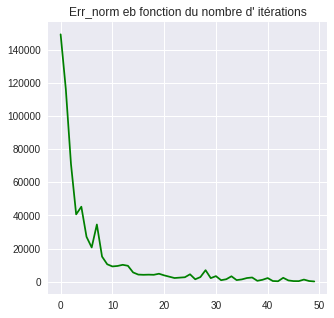

In [65]:
loss_it5 = [trainer_model5.logparser.iterations[i]['error_norm'] for i in range(len(trainer_model5.logparser.iterations))]
it5 = [i for i in range (len(trainer_model5.logparser.iterations))]
fig = plt.figure(figsize=(5,5))
plt.plot(it5,loss_it5, "g")
plt.title('Err_norm eb fonction du nombre d\' itérations')

In [66]:
tagger5 = pycrfsuite.Tagger()
tagger5.open('conll2000-engl.crfsuite')
example_sent_engl = test_sents_engl[0]
print(' '.join(sent2tokens(example_sent_engl)), end='\n\n')
print("Predicted:", ' '.join(tagger5.tag(sent2features(example_sent_engl))))
print("Correct:  ", ' '.join(sent2labels(example_sent_engl)))

Rockwell International Corp. 's Tulsa unit said it signed a tentative agreement extending its contract with Boeing Co. to provide structural parts for Boeing 's 747 jetliners .

Predicted: B-NP I-NP I-NP B-NP I-NP I-NP B-VP B-NP B-VP B-NP I-NP I-NP B-VP B-NP I-NP B-PP B-NP I-NP B-VP I-VP B-NP I-NP B-PP B-NP B-NP I-NP I-NP O
Correct:   B-NP I-NP I-NP B-NP I-NP I-NP B-VP B-NP B-VP B-NP I-NP I-NP B-VP B-NP I-NP B-PP B-NP I-NP B-VP I-VP B-NP I-NP B-PP B-NP B-NP I-NP I-NP O


In [67]:
%%time
y_pred_engl=[tagger5.tag(xseq) for xseq in X_test_engl]

CPU times: user 712 ms, sys: 16 ms, total: 728 ms
Wall time: 728 ms


In [68]:
print(bio_classification_report(y_test_engl, y_pred_engl))

             precision    recall  f1-score   support

     B-ADJP       0.80      0.75      0.77       438
     I-ADJP       0.79      0.66      0.72       167
     B-ADVP       0.84      0.81      0.82       866
     I-ADVP       0.60      0.60      0.60        89
    B-CONJP       0.50      0.56      0.53         9
    I-CONJP       0.67      0.77      0.71        13
     B-INTJ       1.00      0.50      0.67         2
      B-LST       0.00      0.00      0.00         5
      I-LST       0.00      0.00      0.00         2
       B-NP       0.97      0.96      0.97     12422
       I-NP       0.96      0.96      0.96     14376
       B-PP       0.96      0.98      0.97      4811
       I-PP       0.79      0.65      0.71        48
      B-PRT       0.75      0.81      0.78       106
     B-SBAR       0.88      0.82      0.85       535
     I-SBAR       0.13      0.50      0.21         4
       B-VP       0.96      0.96      0.96      4658
       I-VP       0.95      0.96      0.95   

On constate que les scores sont meilleurs avec le corpus anglais qu'avec le corpus espagnol (cela dit les POS tags ne sont pas les mêmes)  
On affiche les poids des transitions

In [69]:
trans_engl = tagger5.info().transitions
index_transition_engl = [i for i in range(len(trans_engl))]
df_transition_engl = pd. DataFrame(trans_engl, index= index_transition_engl, dtype=None)
print(display(df_transition_engl))

B-ADJP                                                             \
       B-ADJP    B-ADVP   B-CONJP      B-NP     B-PP     B-PRT    B-SBAR   
0   -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
1   -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
2   -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
3   -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
4   -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
5   -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
6   -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
7   -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
8   -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
9   -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
10  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
11  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
12  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
13  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
14  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
15  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
16  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
17  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
18  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
19  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
20  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
21  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
22  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
23  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
24  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
25  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
26  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
27  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
28  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
29  -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
..        ...       ...       ...       ...      ...       ...       ...   
332 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
333 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
334 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
335 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
336 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
337 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
338 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
339 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
340 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
341 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
342 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
343 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
344 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
345 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
346 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
347 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
348 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
349 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
350 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0.793606  0.355122   
351 -1.220368 -0.645336 -0.634049 -1.408425  0.19007 -0

None


#### 4.2 Génération de nouvelles features  
  
On va pour cela s'inspirer (fortement!) de plusieurs travaux publiés sur le sujet, notamment:  
* Structure Compilation: Trading Structure for Features (http://nlp.cs.berkeley.edu/pubs/Liang-Daume-Klein_2008_Structure_paper.pdf)  
* https://github.com/aleju/ner-crf
* https://www.analyticsvidhya.com/blog/2017/01/ultimate-guide-to-understand-implement-natural-language-processing-codes-in-python/  
* http://www.chokkan.org/software/crfsuite/tutorial.html  
* https://github.com/nickmarton/NLP/tree/master/CRF  
Pour introduire de nouvelles features, on peut regarder les mots autour du mot à prédire en créant une fenêtre glissante, les n_grammes et l'agencement de la séquence de mots.

In [70]:
def word2features_new(sent, i, ngram_number, window_number):
    """Convert a given word to its set of features for CRF."""
    """ from https://github.com/nickmarton/NLP/tree/master/CRF"""
    
    
    def get_base_features():
        """Obtain the base feature set."""
        base_features = [
            'bias',
            'word.lower=' + word.lower(),
            'word[-3:]=' + word[-3:],
            'word[-2:]=' + word[-2:],
            'word.isupper=%s' % word.isupper(),
            'word.isdigit=%s' % word.isdigit(),
            'postag=' + postag,
            'postag[:2]=' + postag[:2],
        ]

        if i == 0:
            base_features.append('BOS')

        if i == len(sent) - 1:
            base_features.append('EOS')

        return base_features

    def get_ngram_features(ngram_number):
        """Get features based on Ngram number."""
        n = ngram_number

        #if there's a full N-gram for this current word
        if i < len(sent) - n + 1:

            ngram_features = []

            #add features for each word contained in the N-gram
            for j in range(i, i + n):

                word_n = sent[j][0]
                postag_n = sent[j][1]

                ngram_features.extend([
                    '+' + str(j - i + 1) + ':word.lower=' + word_n.lower(),
                    '+' + str(j - i + 1) + ':word[-3:]=' + word_n[-3:],
                    '+' + str(j - i + 1) + ':word[-2:]=' + word_n[-2:],
                    '+' + str(j - i + 1) + ':word.isupper=%s' % word_n.isupper(),
                    '+' + str(j - i + 1) + ':word.isdigit=%s' % word_n.isdigit(),
                    '+' + str(j - i + 1) + ':postag=' + postag_n,
                    '+' + str(j - i + 1) + ':postag[:2]=' + postag_n[:2],
                ])

            return ngram_features
        else:
            return []

    def get_window_features(window_number):
        """Get sliding window features."""

        #get unfiltered window indicies
        unf_indicies = [j for j in range(i - window_number, i + window_number + 1)]

        #filter the indicies to get the valid window indicies
        window_indicies = []
        for j in unf_indicies:
            #eliminate i, and indicies below 0 or above the last token index
            i_cond = j == i
            lb_cond = j < 0
            ub_cond = j > len(sent) - 1

            if not i_cond and not lb_cond and not ub_cond:
                window_indicies.append(j)

        window_features = []

        for w in window_indicies:

            word_n = sent[w][0]
            postag_n = sent[w][1]

            #get prefix for feature
            if w < i:
                prefix = str(w - i)
            if i < w:
                prefix = str(w - i)

            window_features.extend([
                prefix + ':word.lower=' + word_n.lower(),
                prefix + ':word[-3:]=' + word_n[-3:],
                prefix + ':word[-2:]=' + word_n[-2:],
                prefix + ':word.isupper=%s' % word_n.isupper(),
                prefix + ':word.isdigit=%s' % word_n.isdigit(),
                prefix + ':postag=' + postag_n,
                prefix + ':postag[:2]=' + postag_n[:2],
            ])

        return window_features
 
    def get_sequence_features() :
        sequence_features = []
        if i > 1:
            word_b_1 = sent[i - 1][0]
            postag_b_1 = sent[i - 1][1]

            word_b_2 = sent[i - 2][0]
            postag_b_2 = sent[i - 2][1]

            sequence_features.extend([

                # word sequence
                '-1:word.word=' + word_b_1.lower() + word.lower(),

                '-2:word.word=' + word_b_2.lower() + word_b_1.lower(),
                '-2:word.word.word=' + word_b_2.lower() + word_b_1.lower() + word.lower(),

                # tag sequence    
                '-1:postag.postag=' + postag_b_1 + postag,

                '-2:postag.postag=' + postag_b_2 + postag_b_1,
                '-2:postag.postag.postag=' + postag_b_2 + postag_b_1 + postag

            ])
        if i < len(sent) - 2:
            word_a_1 = sent[i + 1][0]
            postag_a_1 = sent[i + 1][1]
            word_a_2 = sent[i + 2][0]
            postag_a_2 = sent[i + 2][1]
            sequence_features.extend([

                # word sequence
                '+1:word.word=' + word.lower() + word_a_1.lower(),

                '+2:word.word=' + word_a_1.lower() + word_a_2.lower(),
                '+2:word.word.word=' + word.lower() + word_a_1.lower() + word_a_2.lower() ,

                # tag sequence    
                '+1:postag.postag=' + postag + postag_a_1,

                '+2:postag.postag=' + postag_a_1 + postag_a_2,
                '+2:postag.postag.postag=' + postag + postag_a_1 + postag_a_2
            ])

        if i > 0 and i < len(sent) - 1:
            word_a_1 = sent[i + 1][0]
            postag_a_1 = sent[i + 1][1]
            word_b_1 = sent[i - 1][0]
            postag_b_1 = sent[i - 1][1]

            sequence_features.extend([
                # word sequence
                '+1:word.word='  + word.lower() + word_a_1.lower(),
                '-1:word.word='  + word_b_1.lower() + word.lower(),

                'word.word.word=' + word_b_1.lower() + word.lower() + word_a_1.lower(), 

                # tag sequence    
                '+1:postag.postag='  + postag + postag_a_1,
                '-1:postag.postag=' + postag_b_1 + postag, 

                'postag.postag.postag=' + postag_b_1 + postag + postag_a_1
            ])
        return sequence_features
    
    features = []

    word = sent[i][0]
    postag = sent[i][1]

    features.extend(get_base_features())
    
    #add Ngram features if not set to default
    if ngram_number != 1:
        features.extend(get_ngram_features(ngram_number))
    
    #add sliding window features if not set to default
    if window_number != 0:
        features.extend(get_window_features(window_number))
        
    features.extend(get_sequence_features())

    return list(set(features))

In [71]:
def sent2features_new(sent, ngram_number=1, window_number=0):
    return [word2features_new(sent, i, ngram_number, window_number) for i in range(len(sent))]
 

On va tester le modèle avec les nouvelles features. Déjà dans un premier temps on vérifie que notre fonction marche bien.

In [72]:
word2features_new(train_sents[0],0,1,0)

['+1:postag.postag=NPFpa',
 'postag=NP',
 '+1:word.word=melbourne(',
 'word.lower=melbourne',
 'word[-2:]=ne',
 '+2:word.word=(australia',
 'BOS',
 'bias',
 'postag[:2]=NP',
 'word.isupper=False',
 '+2:postag.postag.postag=NPFpaNP',
 '+2:postag.postag=FpaNP',
 '+2:word.word.word=melbourne(australia',
 'word.isdigit=False',
 'word[-3:]=rne']

In [73]:
word2features_new(train_sents[0],0,1,1)

['+1:postag.postag=NPFpa',
 'postag=NP',
 'word[-2:]=ne',
 '1:word.isupper=False',
 'bias',
 '1:word[-3:]=(',
 '1:word.isdigit=False',
 'word[-3:]=rne',
 '1:postag[:2]=Fp',
 '+1:word.word=melbourne(',
 '1:word[-2:]=(',
 'word.isdigit=False',
 '1:word.lower=(',
 'BOS',
 '+2:postag.postag.postag=NPFpaNP',
 '+2:word.word.word=melbourne(australia',
 '1:postag=Fpa',
 'word.lower=melbourne',
 '+2:word.word=(australia',
 'postag[:2]=NP',
 'word.isupper=False',
 '+2:postag.postag=FpaNP']

In [74]:
word2features_new(train_sents[0],0,2,1)

['+1:postag.postag=NPFpa',
 'postag=NP',
 '+1:word[-3:]=rne',
 'word[-2:]=ne',
 '1:word.isupper=False',
 'bias',
 '1:word[-3:]=(',
 '1:word.isdigit=False',
 '+2:postag=Fpa',
 '+2:word[-2:]=(',
 'word[-3:]=rne',
 '1:postag[:2]=Fp',
 '+1:word.word=melbourne(',
 '+2:word[-3:]=(',
 '+1:postag[:2]=NP',
 'word.isdigit=False',
 '+2:postag[:2]=Fp',
 '1:word[-2:]=(',
 '1:word.lower=(',
 '+2:word.lower=(',
 'BOS',
 '+1:word.lower=melbourne',
 '+2:postag.postag.postag=NPFpaNP',
 '+1:postag=NP',
 '+2:word.word.word=melbourne(australia',
 '+2:word.isdigit=False',
 '1:postag=Fpa',
 '+1:word.isdigit=False',
 '+2:word.isupper=False',
 'word.lower=melbourne',
 '+2:word.word=(australia',
 '+1:word[-2:]=ne',
 'postag[:2]=NP',
 'word.isupper=False',
 '+2:postag.postag=FpaNP',
 '+1:word.isupper=False']

Notre fonction générant de nouvelles features fonctionne.  
Entrainement du modèle avec un n_gram de 1 et une fenêtre de 2.

In [75]:
X_train_engl = [sent2features_new(s,1,2) for s in train_sents_engl]
y_train_engl = [sent2labels(s) for s in train_sents_engl]

X_test_engl = [sent2features_new(s,1,2) for s in test_sents_engl]
y_test_engl = [sent2labels(s) for s in test_sents_engl]


In [76]:
%%time
trainer_model7 = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train_engl, y_train_engl):
    trainer_model7.append(xseq, yseq)

CPU times: user 14.4 s, sys: 108 ms, total: 14.5 s
Wall time: 14.5 s


In [77]:
trainer_model7.set_params({
    'c1': 0.1,   # coefficient for L1 penalty
    'c2': 0.1,  # coefficient for L2 penalty
    'max_iterations': 50,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [78]:
%%time
trainer_model7.train('conll2000-engl.crfsuite')

CPU times: user 1min 26s, sys: 120 ms, total: 1min 26s
Wall time: 1min 26s


In [79]:
trainer_model7.logparser.last_iteration

{'active_features': 188907,
 'error_norm': 309.423629,
 'feature_norm': 111.211114,
 'linesearch_step': 1.0,
 'linesearch_trials': 1,
 'loss': 5775.80443,
 'num': 50,
 'scores': {},
 'time': 1.549}

CPU times: user 1min 22s, sys: 44 ms, total: 1min 22s
Wall time: 1min 22s


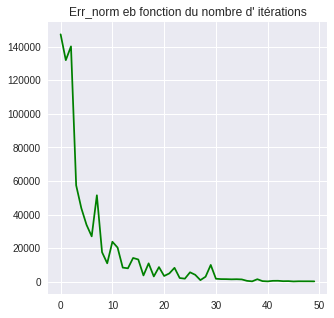

In [80]:
%%time
trainer_model7.train('conll2000-engl.crfsuite')
loss_it7 = [trainer_model7.logparser.iterations[i]['error_norm'] for i in range(len(trainer_model7.logparser.iterations))]
it7 = [i for i in range (len(trainer_model7.logparser.iterations))]
fig = plt.figure(figsize=(5,5))
plt.plot(it7,loss_it7, "g")
plt.title('Err_norm eb fonction du nombre d\' itérations')

In [81]:
tagger7 = pycrfsuite.Tagger()
tagger7.open('conll2000-engl.crfsuite')
example_sent_engl = test_sents_engl[0]
print(' '.join(sent2tokens(example_sent_engl)), end='\n\n')
print("Predicted:", ' '.join(tagger7.tag(sent2features_new(example_sent_engl,1,2))))
print("Correct:  ", ' '.join(sent2labels(example_sent_engl)))


Rockwell International Corp. 's Tulsa unit said it signed a tentative agreement extending its contract with Boeing Co. to provide structural parts for Boeing 's 747 jetliners .

Predicted: B-NP I-NP I-NP B-NP I-NP I-NP B-VP B-NP B-VP B-NP I-NP I-NP B-VP B-NP I-NP B-PP B-NP I-NP B-VP I-VP B-NP I-NP B-PP B-NP B-NP I-NP I-NP O
Correct:   B-NP I-NP I-NP B-NP I-NP I-NP B-VP B-NP B-VP B-NP I-NP I-NP B-VP B-NP I-NP B-PP B-NP I-NP B-VP I-VP B-NP I-NP B-PP B-NP B-NP I-NP I-NP O


Poids des transitions pour ce modèle:

In [82]:
%%time
y_pred7 = [tagger7.tag(xseq) for xseq in X_test_engl]
report7 = bio_classification_report(y_test_engl, y_pred7)
print(report7)
trans7 = tagger7.info().transitions
index_transition7 = [i for i in range(len(trans7))]
df_transition7 = pd. DataFrame(trans7, index= index_transition7, dtype=None)
print(display(df_transition7))

             precision    recall  f1-score   support

     B-ADJP       0.83      0.74      0.79       438
     I-ADJP       0.77      0.67      0.72       167
     B-ADVP       0.86      0.82      0.84       866
     I-ADVP       0.65      0.57      0.61        89
    B-CONJP       0.56      0.56      0.56         9
    I-CONJP       0.71      0.77      0.74        13
     B-INTJ       1.00      0.50      0.67         2
      B-LST       0.00      0.00      0.00         5
      I-LST       0.00      0.00      0.00         2
       B-NP       0.97      0.97      0.97     12422
       I-NP       0.97      0.97      0.97     14376
       B-PP       0.97      0.98      0.98      4811
       I-PP       0.80      0.69      0.74        48
      B-PRT       0.79      0.76      0.78       106
     B-SBAR       0.90      0.86      0.88       535
     I-SBAR       0.13      0.50      0.21         4
       B-VP       0.96      0.96      0.96      4658
       I-VP       0.95      0.96      0.96   

B-ADJP                                                              \
     B-ADJP    B-ADVP   B-CONJP      B-NP      B-PP     B-PRT    B-SBAR   
0   -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
1   -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
2   -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
3   -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
4   -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
5   -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
6   -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
7   -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
8   -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
9   -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
10  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
11  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
12  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
13  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
14  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
15  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
16  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
17  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
18  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
19  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
20  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
21  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
22  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
23  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
24  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
25  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
26  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
27  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
28  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
29  -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
..      ...       ...       ...       ...       ...       ...       ...   
281 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
282 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
283 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
284 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
285 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
286 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
287 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
288 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
289 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
290 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
291 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
292 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
293 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
294 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
295 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
296 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
297 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
298 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
299 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
300 -1.2734 -0.390392 -0.182423 -0.907265  0.198945 -0.058455  0.388196   
301 -1.2734 -0.390392 -0.18242

None
CPU times: user 4 s, sys: 48 ms, total: 4.05 s
Wall time: 3.95 s


On voit que les résultats sont un peu améliorés avec l'introduction de nouveaux features

On peut se demander quelles sont les tailles optimales de la fenêtre et du n_gram? On se restreint à des paramètres compris entre 0 et 3 sinon les calculs sont très longs

In [ ]:
f1_score_engl = []
loss_lastIter_engl = []
errnorm_lastIter_engl = []
wind = [0,1,2,3]
ngram = [0,1,2,3]
k = 8
for w in wind:
    start = time.time()
    for n in ngram:
        X_train_engl = [sent2features_new(s,n,w) for s in train_sents_engl]
        y_train_engl = [sent2labels(s) for s in train_sents_engl]

        X_test_engl = [sent2features_new(s,n,w) for s in test_sents_engl]
        y_test_engl = [sent2labels(s) for s in test_sents_engl]
        
        for xseq, yseq in zip(X_train_engl, y_train_engl):
            trainer_model7.append(xseq, yseq)
        
        
        trainer_model7.set_params({'c1': 0.1, 'c2': 0.1, 'max_iterations': 50,'feature.possible_transitions': True })
        file = 'conll2000-engl'+str(k)+'.crfsuite'
        trainer_model7.train(file)
        lastIter = trainer_model7.logparser.last_iteration
        errnorm = lastIter['error_norm']
        loss = lastIter['loss']
        
        errnorm_lastIter_engl.append(errnorm)
        loss_lastIter_engl.append(loss)
        
        tagger7 = pycrfsuite.Tagger()
        tagger7.open(file)
        y_pred = [tagger7.tag(xseq) for xseq in X_test_engl]
        rep = bio_classification_report(y_test_engl, y_pred)
        f1 = get_avg_f1_from_report(rep)
        f1_score_engl.append(f1)
        print('loop #',k-8)
        print(w,n,f1)
        print('--------------------')
        k += 1
    stop = time.time()
    print(stop-start)
print(errnorm_lastIter_engl)
print(loss_lastIter_engl)
print(f1_score_engl)  

loop # 0
0 0 0.96
--------------------
loop # 1
0 1 0.96
--------------------
loop # 2
0 2 0.96
--------------------
loop # 3
0 3 0.96
--------------------
4711.961463928223
loop # 4
1 0 0.96
--------------------
loop # 5
1 1 0.96
--------------------
loop # 6
1 2 0.96
--------------------
loop # 7
1 3 0.96
--------------------
5751.782306671143
loop # 8
2 0 0.96
--------------------
loop # 9
2 1 0.96
--------------------
loop # 10
2 2 0.96
--------------------
loop # 11
2 3 0.96
--------------------
7449.510057687759
loop # 12
3 0 0.96
--------------------


Les variations de la taille de la fenêtre et du choix du n-gramme ne changent pas le f1-score.

### Conclusion  
  
On a utilisé le notebook CoNLL2002 qui nous a permis de comprendre et d'utiliser pycrfsuite pour analyser du texte d'un corpus espagnol. Les features utilisées prenaient en compte les Part of Speech, la position du mot, s'il commençait ou non par une majuscule ou une minuscule, etc.  
La prédiction des labels s'obtenait avec un score assez bon (autour de 75% si l'on s'en tenait au f1-score) et pouvait être améliorée avec l'optimisation des paramètres de régularisation.  
Nous avons implémenté un algorithme de Viterbi qui nous a permis d'obtenir les mêmes résultats pour la prédiction des labels.  
Nous avons ensuite appliqué ces techniques sur un corpus anglais pour lequel les résultats sont bien meilleurs (de l'ordre de 95%). En ajoutant des features (en prenant en compte un certain nombre de mots autour du mot à prédire par exmple, ou en tenant compte de n-grammes), nous avons un peu amélioré ce score.  
